<a href="https://colab.research.google.com/github/Boyinglby/ADL_lab/blob/main/DL_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2.1 Vanilla GAN

In [ ]:
import torch
import torch.nn.functional as f
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Load Mnist data

In [ ]:
batch_size = 64

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

image_size =28
Z_dim = 100
X_dim = image_size*image_size
# y_dim = train_labels.shape[1]
h_dim = 128
c = 0
lr = 1e-3

# Initiate weight Xavier

In [ ]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

# Generator

In [ ]:
Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def G(z):
    h = f.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = f.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

# Discriminator

In [ ]:
Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)


def D(X):
    h = f.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    y = f.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y


G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

In [ ]:
for i in params:
  print(i.shape)

torch.Size([128])

# Train

In [ ]:
def reset_grad():
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())


G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)


In [ ]:
loss_function = nn.BCELoss()

In [ ]:
#num_epochs = 100000
num_epochs = 5

D_avg_losses = []
G_avg_losses = []

def train_GAN(train_loader, loss_function, G, D, epoch):
  for epoch in range(num_epochs):
    D_losses = 0
    G_losses = 0

    # minibatch training
    for i, (images, _) in enumerate(train_loader):
      mini_batch = images.size()[0]

      ones_label = Variable(torch.ones(mini_batch, 1))
      zeros_label = Variable(torch.zeros(mini_batch, 1))
      # Sample data
      z = Variable(torch.randn(mini_batch, Z_dim))
      X = images.view(-1, X_dim)
      X = Variable(X)

      # Dicriminator forward-loss-backward-update
      G_sample = G(z)
      D_real = D(X)
      D_fake = D(G_sample)

      D_loss_real = loss_function(D_real, ones_label)
      D_loss_fake = loss_function(D_fake, zeros_label)
      D_loss = D_loss_real + D_loss_fake

      D_loss.backward()
      D_solver.step()

      # Housekeeping - reset gradient
      reset_grad()

      # Generator forward-loss-backward-update
      z = Variable(torch.randn(mini_batch, Z_dim))
      G_sample = G(z)
      D_fake = D(G_sample)

      G_loss = loss_function(D_fake, ones_label)

      G_loss.backward()
      G_solver.step()

      # Housekeeping - reset gradient
      reset_grad()

      # loss values
      D_losses += D_loss.data.numpy()
      G_losses += G_loss.data.numpy()

    D_avg_loss = D_losses/mini_batch
    G_avg_loss = G_losses/mini_batch

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    # Print and plot every now and then
    if epoch % 1 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(epoch, D_loss.data.numpy(), G_loss.data.numpy()))

train_GAN(train_loader, loss_function, G, D, 5)

Iter-0; D_loss: 0.7152083516120911; G_loss: 2.0658321380615234
Iter-1; D_loss: 1.1174601316452026; G_loss: 1.7913663387298584
Iter-2; D_loss: 0.9063026905059814; G_loss: 1.8548697233200073
Iter-3; D_loss: 0.9325799345970154; G_loss: 1.7162137031555176
Iter-4; D_loss: 0.6387699246406555; G_loss: 1.5460577011108398


# Plot result

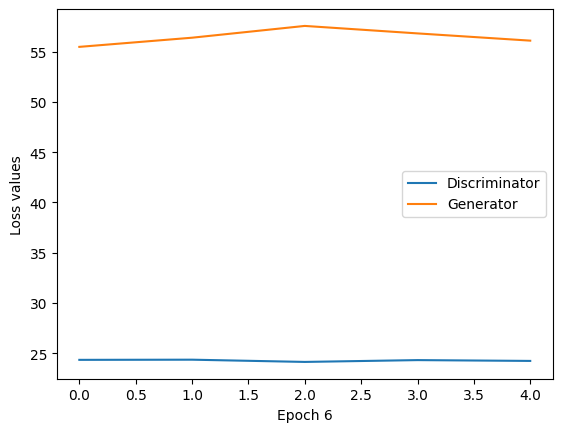

In [ ]:
def plot_loss(d_losses, g_losses, num_epoch):
    fig, ax = plt.subplots()
    plt.xlabel('Epoch {0}'.format(num_epoch + 1))
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

plot_loss(D_avg_losses, G_avg_losses, num_epochs)

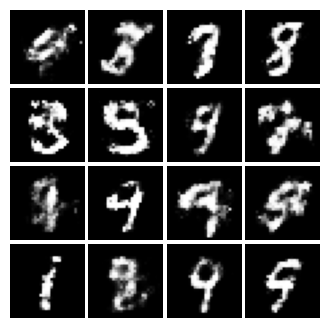

In [ ]:
z = Variable(torch.randn(32, Z_dim))
samples = G(z).data.numpy()[:16]

fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
  ax = plt.subplot(gs[i])
  plt.axis('off')
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_aspect('equal')
  plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

# Task 2.3 CGAN

In [ ]:
y_dim = 10

In [ ]:
Wzh = xavier_init(size=[Z_dim + y_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

def G_c(z, c):

    inputs = torch.cat([z, c], 1)

    h = f.relu(inputs @ Wzh + bzh.repeat(inputs.size(0), 1))
    X = f.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

In [ ]:
Wxh = xavier_init(size=[X_dim + y_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)

def D_c(X, c):
    inputs = torch.cat([X, c], 1)
    h = f.relu(inputs @ Wxh + bxh.repeat(inputs.size(0), 1))
    y = f.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y

In [ ]:
G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

In [ ]:
for i in params:
  print(i.shape)

torch.Size([110, 128])
torch.Size([128])
torch.Size([128, 784])
torch.Size([784])
torch.Size([794, 128])
torch.Size([128])
torch.Size([128, 1])
torch.Size([1])


In [ ]:
to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)

def train_CGAN(train_loader, loss_function, G_c, D_c, epoch):

  for epoch in range(num_epochs):
    D_losses = 0
    G_losses = 0

    # minibatch training
    for i, (images, c) in enumerate(train_loader):
      mini_batch = images.size()[0]

      ones_label = Variable(torch.ones(mini_batch, 1))
      zeros_label = Variable(torch.zeros(mini_batch, 1))
      # Sample data
      z = Variable(torch.randn(mini_batch, Z_dim))
      X = images.view(-1, X_dim)
      X = Variable(X)

      # Dicriminator forward-loss-backward-update
      c = to_onehot(c)

      G_sample = G_c(z, c)
      D_real = D_c(X, c)
      D_fake = D_c(G_sample, c)

      D_loss_real = loss_function(D_real, ones_label)
      D_loss_fake = loss_function(D_fake, zeros_label)
      D_loss = D_loss_real + D_loss_fake

      D_loss.backward()
      D_solver.step()

      # Housekeeping - reset gradient
      reset_grad()

      # Generator forward-loss-backward-update
      z = Variable(torch.randn(mini_batch, Z_dim))
      G_sample = G_c(z,c)
      D_fake = D_c(G_sample,c)

      G_loss = loss_function(D_fake, ones_label)

      G_loss.backward()
      G_solver.step()

      # Housekeeping - reset gradient
      reset_grad()

      # loss values
      D_losses += D_loss.data.numpy()
      G_losses += G_loss.data.numpy()

    D_avg_loss = D_losses/mini_batch
    G_avg_loss = G_losses/mini_batch

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    # Print and plot every now and then
    if epoch % 1 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(epoch, D_loss.data.numpy(), G_loss.data.numpy()))


In [ ]:
num_epochs = 10

D_avg_losses = []
G_avg_losses = []
train_CGAN(train_loader, loss_function, G_c, D_c, num_epochs)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

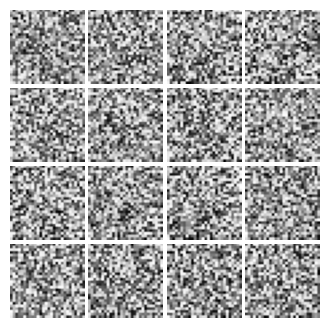

In [ ]:
z = Variable(torch.randn(32, Z_dim))
c = np.zeros(shape=[32, 1], dtype='float32')
c[:] = 0.
c = Variable(torch.from_numpy(c))
samples = G_c(z,c).data.numpy()[:16]

fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
  ax = plt.subplot(gs[i])
  plt.axis('off')
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_aspect('equal')
  plt.imshow(sample.reshape(28, 28), cmap='Greys_r')